In [1]:
import pandas as pd
from connector import sql_to_df

# Import data for the Sales Forecast Application

First, retrive data from the database:

* We only want bikes, which have a product sub-category in 1 (mountain bikes), 2 (road bikes) and 3 (touring bikes).
* We retrieve the columns we need for the app, not more. We clean the data by trimming the columns with a `CHAR` type, and we transform the columns for better visualizations (day of week as 2-letter codes) and sub-categories as text instead of codes (*note that the original -complete_ AdventureWorksDW database has a subcategory table, here we just add a `CASE WHEN` statement to handle it*).


In [2]:
df_sales = sql_to_df(
    """
SELECT
	fulldatealternatekey AS date,
	CASE
		WHEN daynumberofweek = 1 THEN 'Su'
		WHEN daynumberofweek = 2 THEN 'Mo'
		WHEN daynumberofweek = 3 THEN 'Tu'
		WHEN daynumberofweek = 4 THEN 'We'
		WHEN daynumberofweek = 5 THEN 'Th'
		WHEN daynumberofweek = 6 THEN 'Fr'
		WHEN daynumberofweek = 7 THEN 'Sa'
		ELSE '??'
	END AS day,
	productalternatekey AS product,
	CASE 
		WHEN productsubcategorykey = 1 THEN 'Mountain'
		WHEN productsubcategorykey = 2 THEN 'Road'
		WHEN productsubcategorykey = 3 THEN 'Touring'
		ELSE 'UNKNOWN'
	END AS type,
	englishproductname AS name,
	color AS color,
	trim(style) AS style, 
	customeralternatekey AS customer,
	extract(year from birthdate) AS birth,
	CASE WHEN extract(year from birthdate) > 1980 THEN 'Millenial'
		WHEN extract(year from birthdate) BETWEEN 1966 AND 1980 THEN 'Gen X'
        WHEN extract(year from birthdate) BETWEEN 1945 AND 1965 THEN 'Boomers'
        WHEN extract(year from birthdate) < 1945 THEN 'Silent'
        ELSE 'Unknown'
    END AS generation,
	gender AS gender,
	unitprice AS unit_price,
	orderquantity AS items,
	unitprice * orderquantity AS sales
FROM
    factinternetsales
	JOIN dimproduct ON dimproduct.productkey = factinternetsales.productkey
	JOIN dimdate on  dimdate.datekey = factinternetsales.orderdatekey
	JOIN dimcustomer on dimcustomer.customerkey = factinternetsales.customerkey
WHERE 
	productsubcategorykey IN (1, 2, 3)"""
)

In [3]:
df_sales.sample(4)

,date,day,product,type,name,color,style,customer,birth,generation,gender,unit_price,items,sales
4421,2012-09-21,Fr,BK-M68S-46,Mountain,"Mountain-200 Silver, 46",Silver,U,AW00014236,1981.0,Millenial,F,2071.4196,1,2071.4196
14551,2013-12-12,Th,BK-R64Y-48,Road,"Road-550-W Yellow, 48",Yellow,W,AW00021931,1966.0,Gen X,M,1120.4900,1,1120.4900
12799,2013-10-26,Sa,BK-R19B-44,Road,"Road-750 Black, 44",Black,U,AW00025562,1985.0,Millenial,F,539.9900,1,539.9900
405,2011-03-22,Tu,BK-R93R-62,Road,"Road-150 Red, 62",Red,U,AW00017056,1975.0,Gen X,M,3578.2700,1,3578.2700


In [4]:
df_sales.dtypes

date           object
day            object
product        object
type           object
name           object
color          object
style          object
customer       object
birth         float64
generation     object
gender         object
unit_price    float64
items           int64
sales         float64
dtype: object

In [5]:
# DataFrame size before type transformation
print(
    f"DataFrame size before changing data types: {round(df_sales.memory_usage(deep=True).sum()/(1024*1024), 2)} Mb"
)

DataFrame size before changing data types: 8.32 Mb


In [6]:
df_sales = df_sales.astype(
    {
        "date": "datetime64[ns]",
        "day": "category",
        "product": "category",
        "type": "category",
        "name": str,
        "color": "category",
        "style": "category",
        "customer": "category",
        "birth": "int",
        "generation": str,
        "gender": "category",
        "unit_price": "float",
        "items": "int",
        "sales": "float",
    }
)

In [7]:
print(
    f"DataFrame size after changing data types: {round(df_sales.memory_usage(deep=True).sum()/(1024*1024), 2)} Mb"
)

DataFrame size after changing data types: 3.27 Mb


## Explorations

We can plot some of the data to see how it's distributed, and look for anomalies.

In [8]:
df_sales[df_sales["sales"] < 0]

,date,day,product,type,name,color,style,customer,birth,generation,gender,unit_price,items,sales


In [9]:
df_sales.isnull().any().any()

np.False_

We don't have negative sales, and we don't have missing values, this dataset is rather clean.

Let's look at sales evolution:

In [10]:
def group_by_dimensions_and_facts(df, dimension_columns, orderby="sales"):
    """
    Groups a DataFrame by specified dimension columns, always aggregating:
        - Count by the "quantity" column.
        - Sum the "total_sale" column.

    Args:
        df (pd.DataFrame): The input DataFrame to group.
        dimension_columns (list of str): List of column names to group by (dimensions).
        orderby (str | list of str): columns name or list of columns to order the DataFrame. Defaults to "sales"


    Returns:
        pd.DataFrame: A grouped DataFrame with the sum of "total_sale" and count of "quantity" for each combination of dimensions.
    """
    df_copy = df.copy()

    # Sum "total_sale" and count "quantity"
    df_grouped = df_copy.groupby(dimension_columns, observed=True).agg(
        sales=("sales", "sum"), items=("items", "count")
    )

    df_grouped = df_grouped.sort_values(by=orderby, ascending=False)

    # Format and return the DataFrame
    df_grouped = df_grouped.round(2)
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [11]:
df_sales_by_date = group_by_dimensions_and_facts(df_sales, ["date"], orderby="date")
df_sales_by_date.head(2)

,date,sales,items
0,2013-12-28,45779.42,26
1,2013-12-27,57803.94,40


<Axes: xlabel='date', ylabel='sales'>

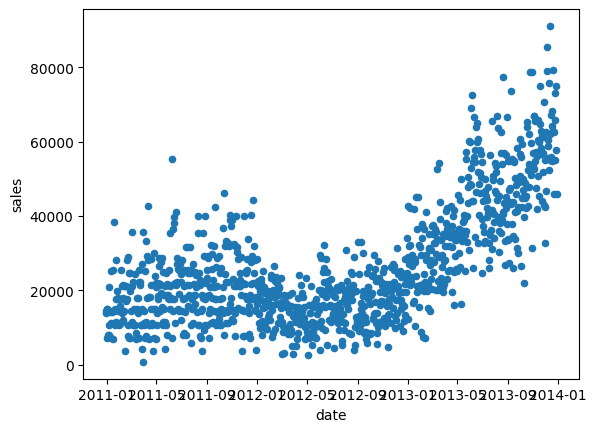

In [12]:
df_sales_by_date.plot(x="date", y="sales", kind="scatter")

## Create a simplified DataFrame

By creating a smaller DataFrame, we can increase the efficiency of the application.

We'll still use the bigger DataFrame to display data, in a table that doesn't update. But we can create a second subset, with less columns and some level of pre-aggregation to reduce the required effort to aggreate data.

We remove the following columns, that we won't use for aggregation:

* product (the product ID, we'll use the "name", it's less efficient, but better for end users).
* customer (the customer ID).
* birth (we won't aggregate by birthdate -not enough data-, but by "generation").

In [13]:
len(df_sales)

15205

In [14]:
df_sales_simplified = group_by_dimensions_and_facts(
    df_sales,
    [
        "date",
        "day",
        "type",
        "name",
        "color",
        "style",
        "generation",
        "gender",
        "unit_price",
    ],
)
df_sales_simplified.head()

,date,day,type,name,color,style,generation,gender,unit_price,sales,items
0,2011-06-07,Tu,Road,"Road-150 Red, 62",Red,U,Gen X,M,3578.27,14313.08,4
1,2011-05-16,Mo,Road,"Road-150 Red, 52",Red,U,Gen X,F,3578.27,10734.81,3
2,2011-05-08,Su,Road,"Road-150 Red, 56",Red,U,Gen X,M,3578.27,10734.81,3
3,2011-05-24,Tu,Road,"Road-150 Red, 44",Red,U,Gen X,M,3578.27,10734.81,3
4,2011-06-17,Fr,Road,"Road-150 Red, 48",Red,U,Gen X,F,3578.27,10734.81,3


In [15]:
len(df_sales_simplified)

14242

### Aggregate by customer type

This will only be used for table display, we'll use the simplified DataFrame for charts.

In [16]:
df_sales_by_customer = group_by_dimensions_and_facts(
    df_sales, ["customer", "birth", "generation", "gender"]
)


df_sales_by_customer.head()

,customer,birth,generation,gender,sales,items
0,AW00012300,1952,Boomers,F,13109.75,5
1,AW00012131,1961,Boomers,M,13109.75,5
2,AW00012301,1952,Boomers,F,13109.75,5
3,AW00012321,1956,Boomers,F,13084.75,5
4,AW00012308,1970,Gen X,F,13084.75,5


### Aggregate by product type

This will only be used for table display, we'll use the simplified DataFrame for charts

In [17]:
df_sales_by_product = group_by_dimensions_and_facts(
    df_sales,
    [
        "product",
        "name",
        "type",
        "color",
        "style",
        "unit_price",
    ],
)
# We use the maximum unit_price value
df_sales_by_product = (
    df_sales_by_product.groupby(
        ["product", "name", "type", "color", "style"], observed=True
    )
    .agg({"unit_price": "max", "sales": "sum", "items": "sum"})
    .sort_values(by="sales", ascending=False)
    .round(2)
    .reset_index()
)

df_sales_by_product.head()

,product,name,type,color,style,unit_price,sales,items
0,BK-M68B-46,"Mountain-200 Black, 46",Mountain,Black,U,2294.99,1373469.55,620
1,BK-M68B-42,"Mountain-200 Black, 42",Mountain,Black,U,2294.99,1363142.09,614
2,BK-M68S-38,"Mountain-200 Silver, 38",Mountain,Silver,U,2319.99,1339462.79,596
3,BK-M68S-46,"Mountain-200 Silver, 46",Mountain,Silver,U,2319.99,1301100.10,580
4,BK-M68B-38,"Mountain-200 Black, 38",Mountain,Black,U,2294.99,1294866.14,582


## Save DataFrames

We save each DataFrame:

* As CSV, for reference and so we can have a quick way to inspect data manually when we want to debug or as we build our dashboard, or to check some data with our clients.
* As a parquet file for our application, it's a more efficient format.

In [18]:
# Save csv files

df_sales.to_csv("./csv_files/sales.csv", index=False)
df_sales_simplified.to_csv("./csv_files/sales_simplified.csv", index=False)
df_sales_by_customer.to_csv("./csv_files/sales_by_customer.csv", index=False)
df_sales_by_product.to_csv("./csv_files/sales_by_product.csv", index=False)

In [19]:
df_sales.to_parquet("../src/data/sales.parquet", index=False)
df_sales_simplified.to_parquet("../src/data/sales_simplified.parquet", index=False)
df_sales_by_customer.to_parquet("../src/data/sales_by_customer.parquet", index=False)
df_sales_by_product.to_parquet("../src/data/sales_by_product.parquet", index=False)